# 3. Make sure to check near harmonics in your periodogram for hiding planets

Planets often occur in near resonances, meaning that in a BLS, a signal for a second transiting planet may be close to the harmonics of the first transiting planet. When executing a planet search, be sure to mask transits and repeat your search, in order find these hiding planets!

In this notebook I will show you a **third unknown K2 Planet Candidate**, hiding next to the harmonics of a larger, longer period planet. 

K2-168b was first identified and confirmed in [Mayo et al 2018](https://arxiv.org/pdf/1802.05277.pdf). A smaller, shorter period planet is also hiding in this dataset; planet candidate K2-168c. However, the two planets are nearly at a 2:1 resonance, meaning that in a BLS periodogram the harmonics will overlap. Furthermore, the transits of the 
shorter period, smaller planet occur very close to the transits of the larger planet.

Below I use the `lightkurve` package to show the second, hiding planet candidate!

In [2]:
import lightkurve as lk
from scripts import fetch_hlsps
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(lk.MPLSTYLE)

In [3]:
# Download the data from MAST
lcf = lk.search_lightcurvefile('EPIC 205950854').download()

Text(0.5,1,'EPIC 205950854 Campaign 3')

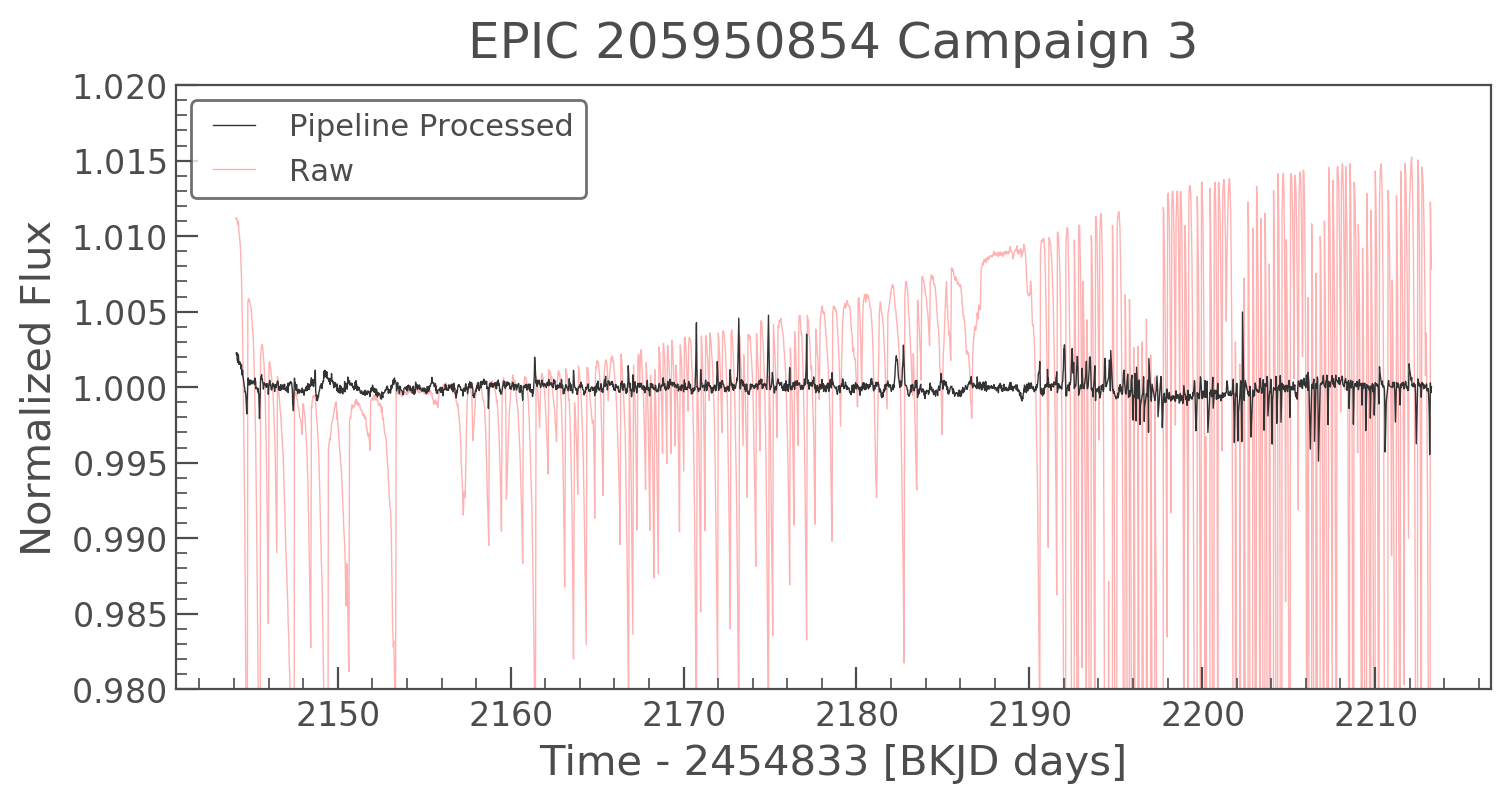

In [58]:
# Plot the data
ax = lcf.PDCSAP_FLUX.remove_outliers(10).plot(label='Pipeline Processed')

lcf.SAP_FLUX.remove_outliers(10).plot(ax=ax, label='Raw', c='r', alpha=0.3, zorder=-10)
ax.set_ylim(0.98, 1.02)
ax.set_title('EPIC {} Campaign {}'.format(lcf.targetid, lcf.campaign))

Text(0.5,1,'EPIC 205950854 Campaign 3')

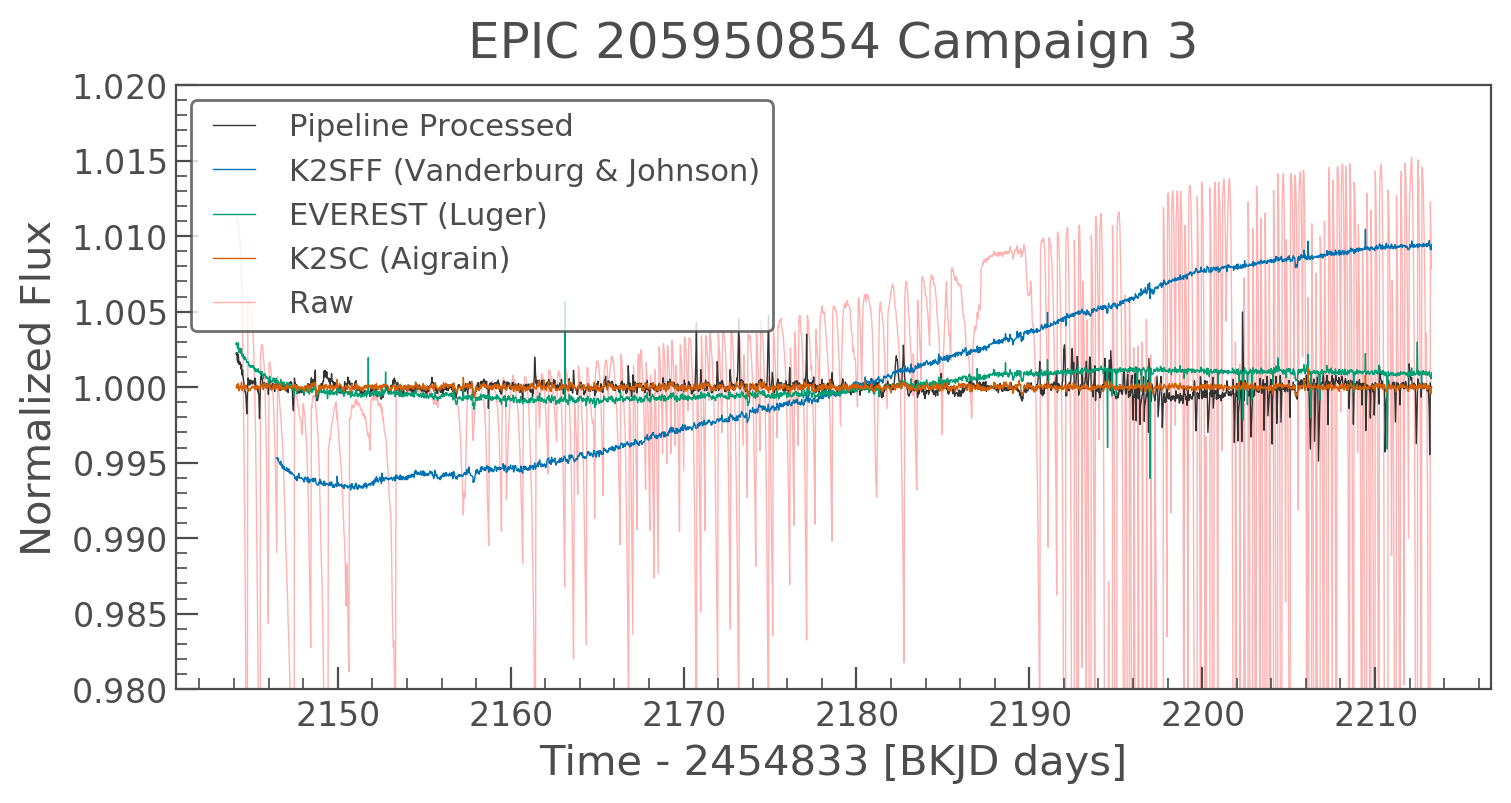

In [9]:
# Plot the data
ax = lcf.PDCSAP_FLUX.remove_outliers(10).plot(label='Pipeline Processed')
hlsps = fetch_hlsps(lcf.PDCSAP_FLUX)
for hlsp in hlsps:
    hlsp.remove_outliers(10).plot(ax=ax)

lcf.SAP_FLUX.remove_outliers(10).plot(ax=ax, label='Raw', c='r', alpha=0.3, zorder=-10)

ax.set_ylim(0.98, 1.02)
ax.set_title('EPIC {} Campaign {}'.format(lcf.targetid, lcf.campaign))

We can see that unlike the previous two cases, this light curve is relatively flat. This should make finding planets much easier. I've shown in the first notebook how we might go about finding planets using `lightkurve`. As before, I'm just going to give the period and transit midpoint of the planet, and leave the discovering as an exercise to the reader.

In [10]:
period_1, duration_1, t0_1 = 15.853989, 0.3, 1.73029748
period_2, duration_2, t0_2 = 8.050738098098098, 0.2, 7.313128252092177

We can see that these two planets are very close to a 2:1 resonance:

In [47]:
print(period_2/period_1)

0.5078052027220467


Let's plot the known planet K2-168b, (p $\sim$ 15 days). Below I'm showing the transit signal for each of the three HLSPs.

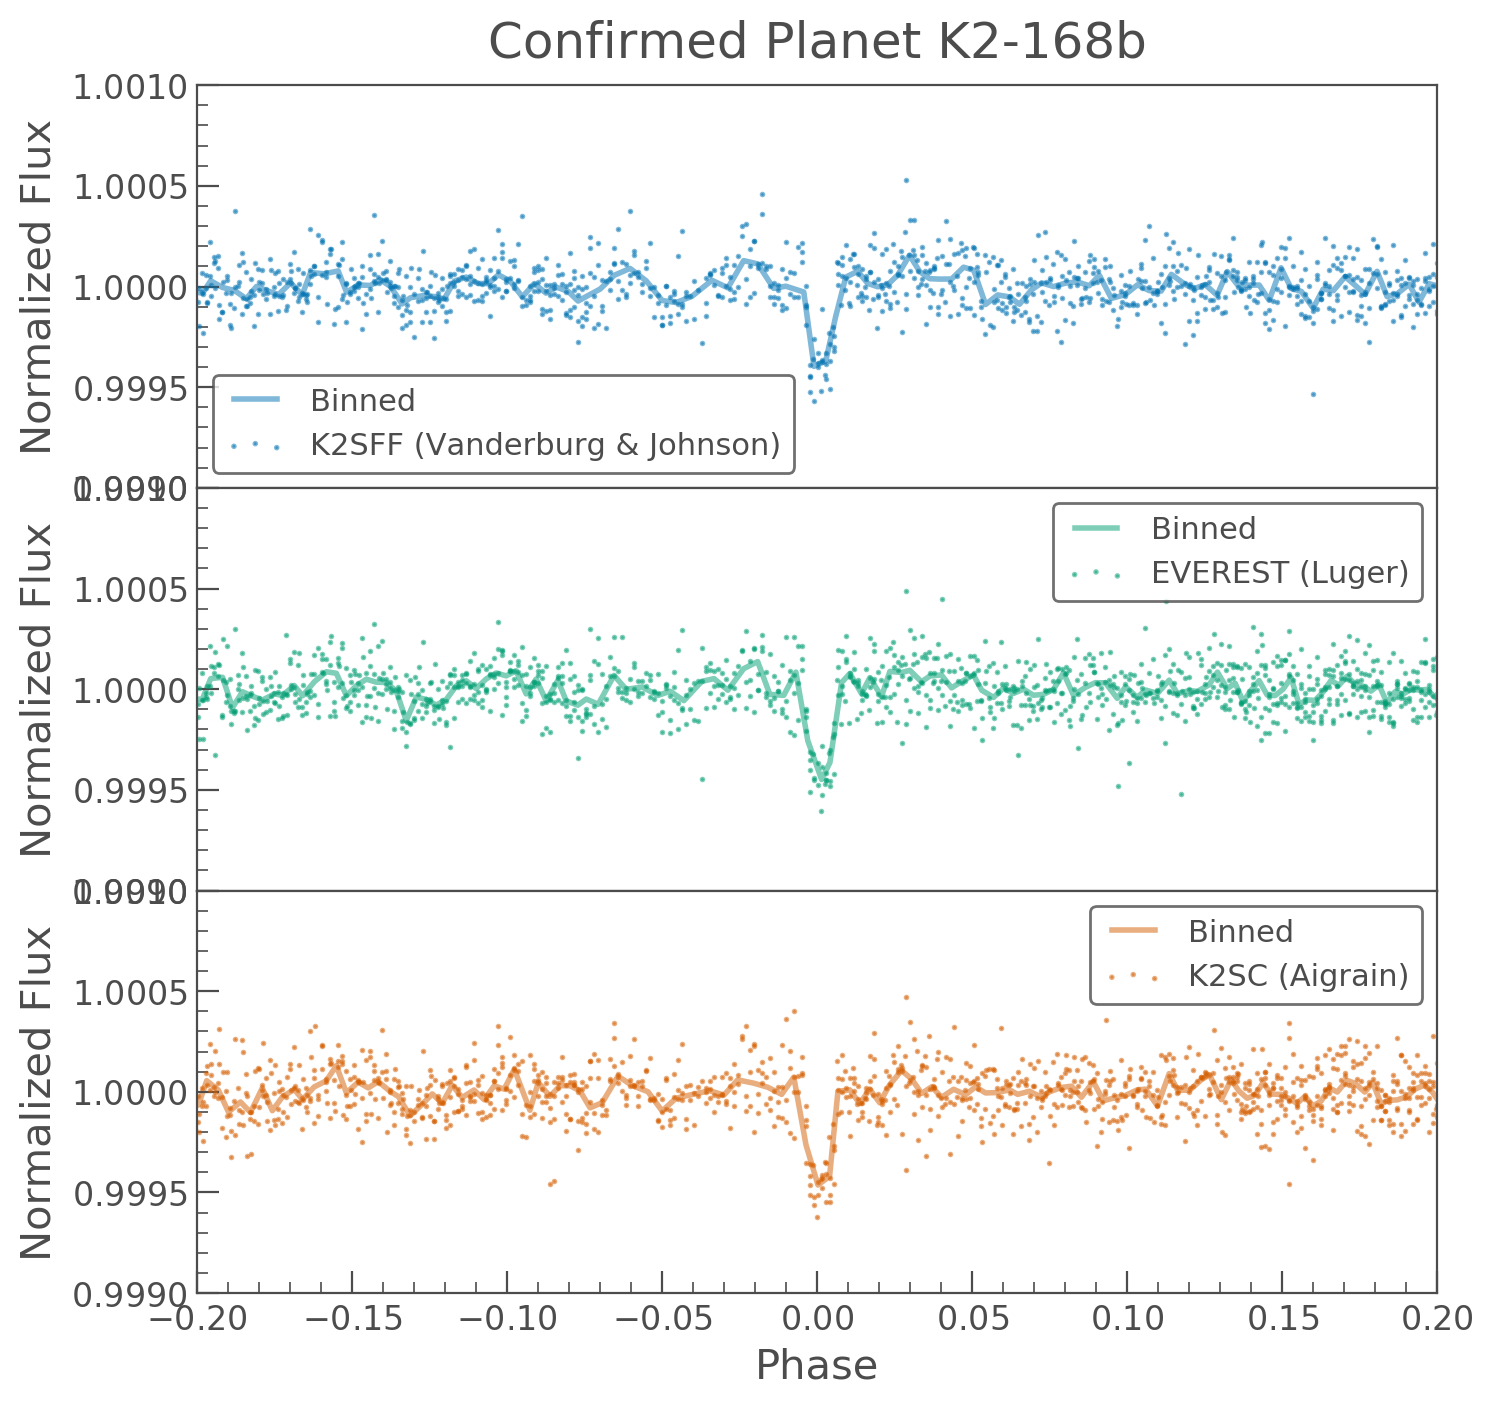

In [43]:
fig, ax = plt.subplots(3, figsize=(8, 8))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_2)/period_2 % 1
    out_of_transit = (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)
    
    lc1 = lc1.flatten(window_length=81, mask=~out_of_transit)
    lc1 = lc1[out_of_transit].remove_outliers(5)
    lc1.fold(period_1, t0_1).scatter(ax=ax[idx], c= 'C{}'.format(idx + 1), alpha=0.5, zorder=2)
    lc1.fold(period_1, t0_1).bin(10, 'median').plot(ax=ax[idx], c= 'C{}'.format(idx + 1), lw=2, alpha=0.5, label='Binned', zorder=1)

    ax[idx].set_xlim(-0.2, 0.2)
    ax[idx].set_ylim(0.999, 1.001)
    if idx < 2:
        ax[idx].set_xticks([])
    if idx == 0:
        ax[idx].set_title('Confirmed Planet K2-168b')
plt.subplots_adjust(hspace=0)

And if we fold on the parameters of the second signal, we see that the second planet candidate becomes apparent.

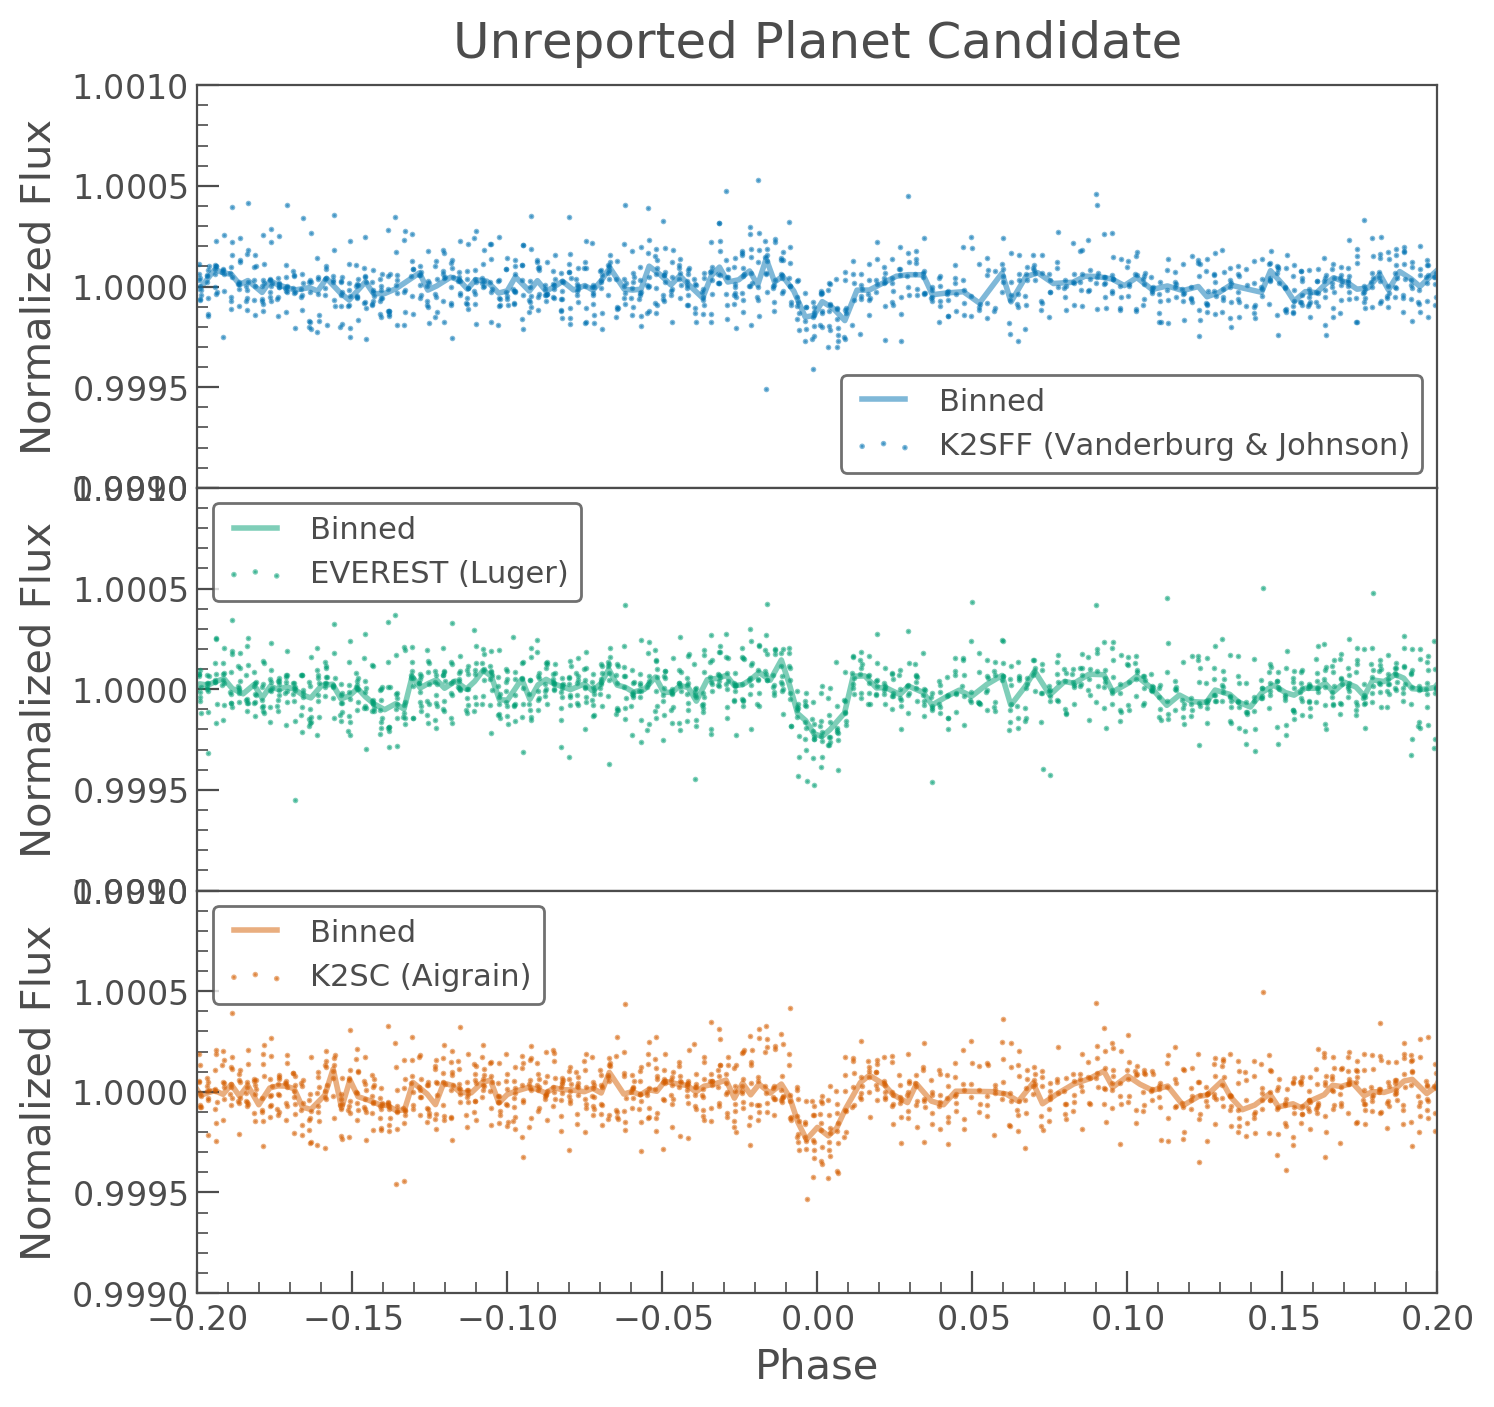

In [52]:
fig, ax = plt.subplots(3, figsize=(8, 8))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_1)/period_1 % 1
    out_of_transit = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
    
    lc1 = lc1.flatten(window_length=81, mask=~out_of_transit)
    lc1 = lc1[out_of_transit].remove_outliers(5)
    lc1.fold(period_2, t0_2).scatter(ax=ax[idx], c= 'C{}'.format(idx + 1), alpha=0.5, zorder=2)
    lc1.fold(period_2, t0_2).bin(10, 'median').plot(ax=ax[idx], c= 'C{}'.format(idx + 1), lw=2, alpha=0.5, label='Binned', zorder=1)

    ax[idx].set_xlim(-0.2, 0.2)
    ax[idx].set_ylim(0.999, 1.001)
    if idx < 2:
        ax[idx].set_xticks([])
    if idx == 0:
        ax[idx].set_title('Unreported Planet Candidate')

plt.subplots_adjust(hspace=0)

We can look at a BLS periodogram to see where this transit falls in period space.

In [22]:
p = hlsps[2].remove_nans().to_periodogram('bls', minimum_period=1, maximum_period=25, frequency_factor=0.1)

`period` contains 183569 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


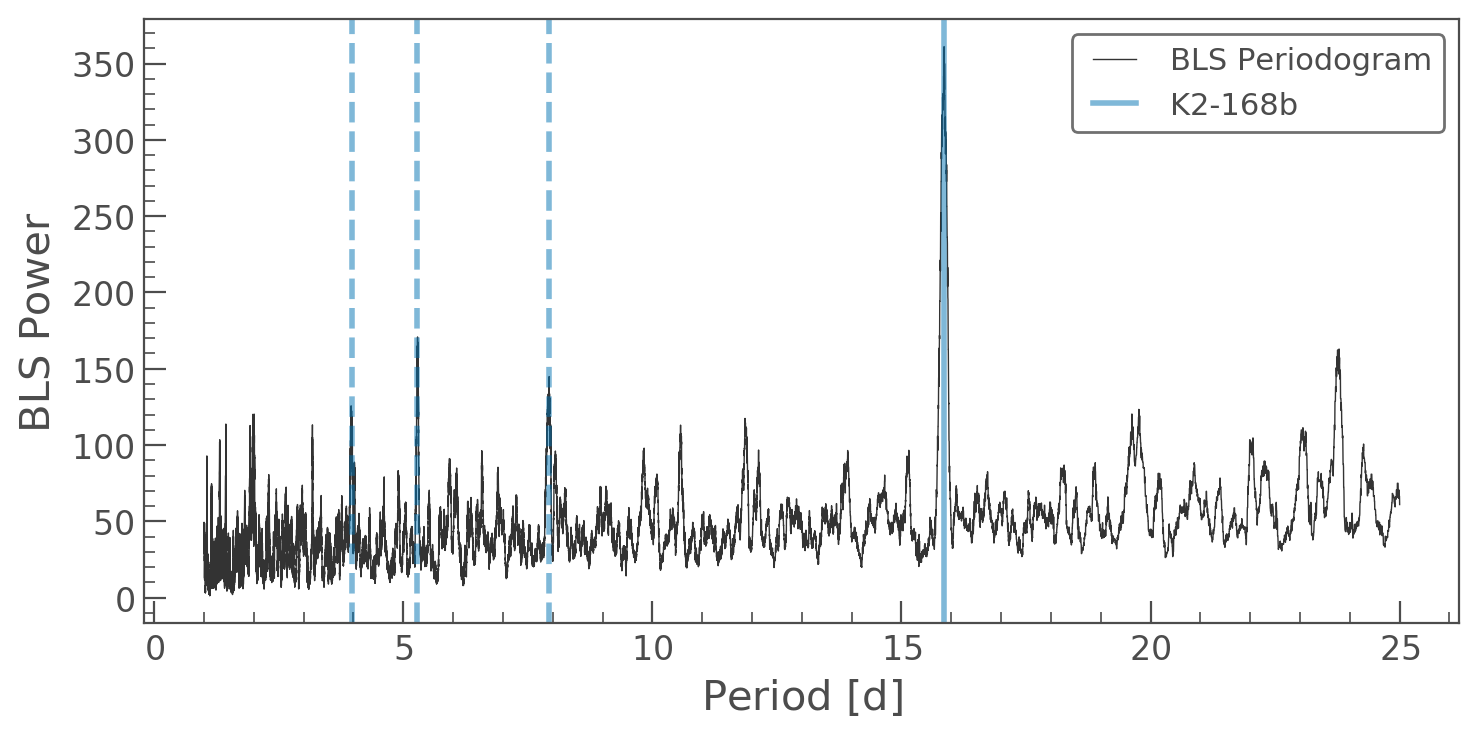

In [50]:
ax = p.plot(label='BLS Periodogram')
ax.axvline(period_1, c='C1', lw=2, alpha=0.5, label='K2-168b')
for idx in range(3):
    ax.axvline(period_1/(idx + 2), c='C1', lw=2, alpha=0.5, ls='--')
plt.legend(loc=1)

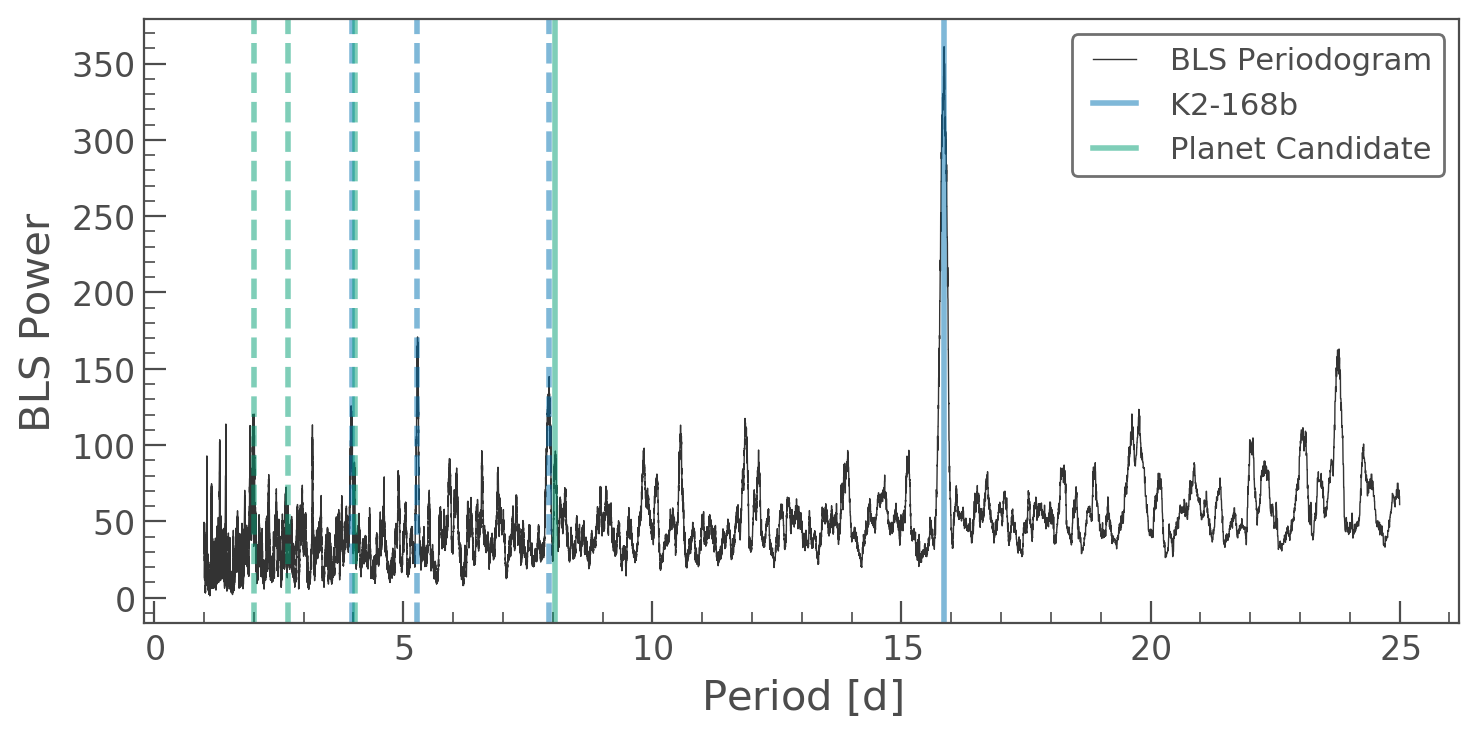

In [51]:
ax = p.plot(label='BLS Periodogram')
ax.axvline(period_1, c='C1', lw=2, alpha=0.5, label='K2-168b')
for idx in range(3):
    ax.axvline(period_1/(idx + 2), c='C1', lw=2, alpha=0.5, ls='--')

    
ax.axvline(period_2, c='C2', lw=2, alpha=0.5, label='Planet Candidate')
for idx in range(3):
    ax.axvline(period_2/(idx + 2), c='C2', lw=2, alpha=0.5, ls='--')

plt.legend(loc=1)

As shown above, the peak power of the planet candidate lies almost exactly on a harmonic from K2-168b. If these peaks were clipped out before running another planet search, this candidate would have been missed.

We can also plot the times that the transits occurred, as shown below.

(0.9985, 1.001)

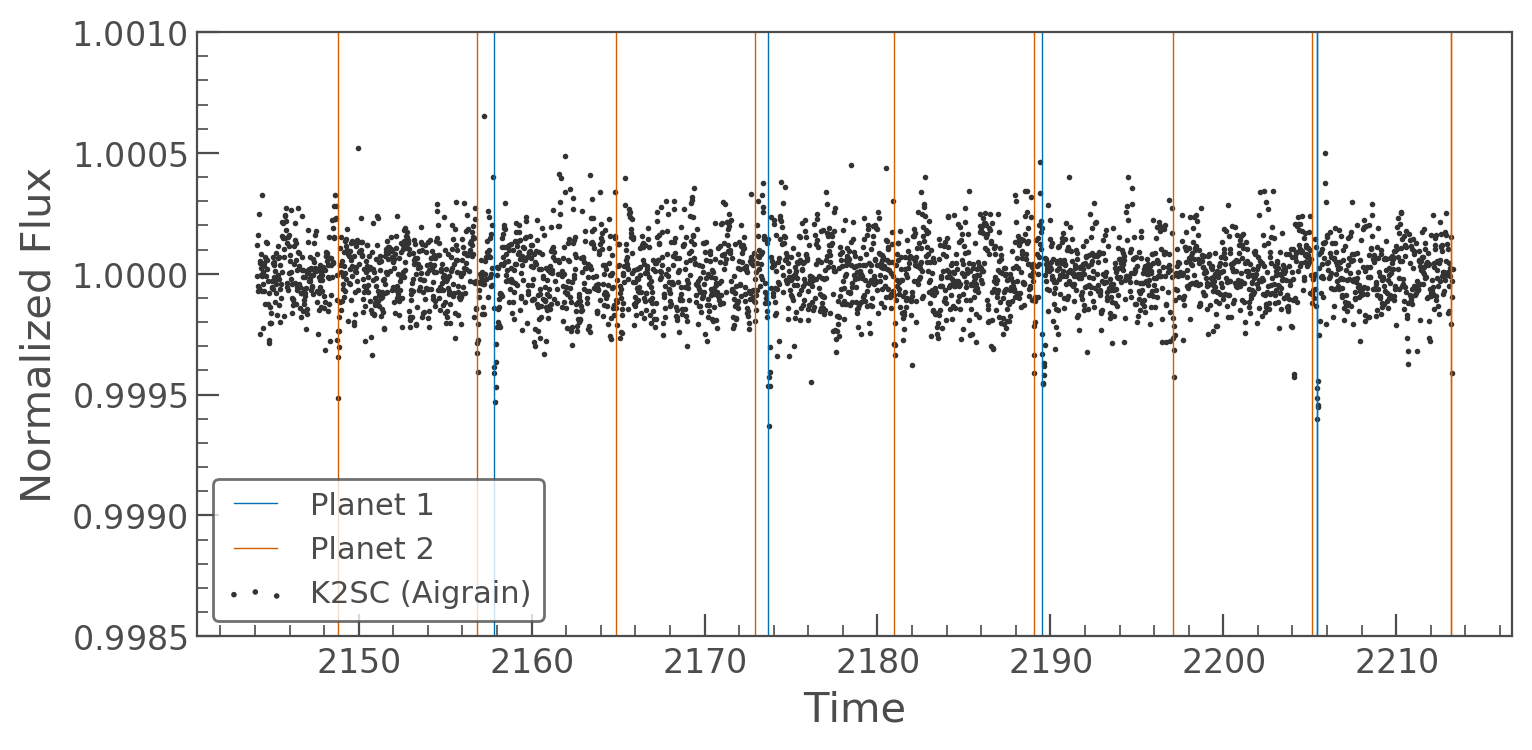

In [42]:
# Mask planet 2
lc1 = hlsps[2]
lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
lc1 = lc1.remove_nans().normalize().remove_outliers(5)
#ax = lc1.scatter(alpha=0.5, marker='s')
lc1 = lc1[lc1.flux > 0.8]
ph = (lc1.time - t0_1)/period_1 % 1
out_of_transit = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
ph = (lc1.time - t0_2)/period_2 % 1
out_of_transit &= (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)


#lc1 = lc1.flatten(window_length=41, mask=~out_of_transit).remove_outliers(5)
ax = lc1.scatter()

ph = (lc1.time - t0_1) / period_1 % 1
for t0 in lc1.time[np.where(np.diff(ph) < -0.5)[0] - 1]:
    ax.axvline(t0, c='C1')
ax.axvline(t0, c='C1', label='Planet 1')

ph = (lc1.time - t0_2) / period_2 % 1
for t0 in lc1.time[np.where(np.diff(ph) < -0.5)[0] - 1]:
    ax.axvline(t0, c='C3')
ax.axvline(t0, c='C3', label='Planet 2')
plt.legend()

ax.set_ylim(0.9985, 1.001)

Here we see that the half transits of the unknown planet candidate (shown in orange) occur within a day of transits of K2-168b. If these data were removed before searching for any further transiting planet, the signal of the second planet would be greatly reduced.

These two factors lead to it being hard to find transiting planet candidates that are close to harmonics. Such cases require careful attention, and can be missed by pipelines.